# Pose Fusion Net Model + Dataset Loading (PyTorch)

In [1]:
%pip install torch pandas numpy matplotlib
%pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 66.5 MB 1.1 MB/s eta 0:00:013
     |████████████████████████████████| 194 kB 22.6 MB/s eta 0:00:01
     |████████████████████████████████| 6.2 MB 18.8 MB/s eta 0:00:01
     |████████████████████████████████| 134 kB 21.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 23.6 MB/s eta 0:00:01
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.6.1-cp39-cp39-macosx_12_0_arm64.whl (11.1 MB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached scipy-

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import ast
import time
import os
from datetime import datetime

# DATASET INITIALIZATION
class OdometryLiDARDataset(Dataset):
    def __init__(self, csv_path, T=20, max_range=30.0):
        self.T = T # LSTM sequence length
        self.max_range = max_range
        self.data = pd.read_csv(csv_path)
        self.data = self.data.sort_values(by='Time').reset_index(drop=True)

        self.odom = self.data[['Odom_X', 'Odom_Y', 'Odom_Yaw']].values
        self.gt_pose = self.data[['GT_X', 'GT_Y', 'GT_Yaw']].values

        # Apply offsets to odom data
        self.odom[:, 0] += 75.82665864
        self.odom[:, 1] += 107.72466521
        print(f"Applied fixed odometry offset correction: Δx = 75.827, Δy = 107.725")

        self.odom[:, 2] += -0.14862029
        print(f"Applied fixed yaw offset correction: Δyaw = -0.149 radians (≈ -8.52°)")

        self.lidar = []
        for lx, ly in zip(self.data['LiDAR_X'], self.data['LiDAR_Y']):
            x_vals = np.array(ast.literal_eval(lx))
            y_vals = np.array(ast.literal_eval(ly))
            ranges = np.sqrt(x_vals**2 + y_vals**2)
            ranges[ranges == 0] = self.max_range
            ranges = ranges / self.max_range
            self.lidar.append(ranges)
        self.lidar = np.array(self.lidar)

    def __len__(self):
        return len(self.odom) - self.T

    def __getitem__(self, idx):
        odom_seq = self.odom[idx:idx + self.T]
        lidar_seq = self.lidar[idx:idx + self.T]
        target_pose = self.gt_pose[idx + self.T - 1]

        return {
            'odom': torch.tensor(odom_seq, dtype=torch.float32),
            'lidar': torch.tensor(lidar_seq, dtype=torch.float32),
            'pose': torch.tensor(target_pose, dtype=torch.float32),
        }

# MODEL DEFINITION
class OdometryLiDARNet(nn.Module):
    def __init__(self, lidar_dim, output_dim=3):
        super().__init__()
        self.odom_lstm = nn.LSTM(input_size=3, hidden_size=64, num_layers=1, batch_first=True)

        self.lidar_cnn = nn.Sequential(
            nn.Conv1d(in_channels=20, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )

        self.fusion_fc = nn.Sequential(
            nn.Linear(64 + 128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    # Custom forward propagation function
    def forward(self, odom_seq, lidar_seq):
        odom_feat, _ = self.odom_lstm(odom_seq)
        odom_feat = odom_feat[:, -1, :]

        lidar_feat = self.lidar_cnn(lidar_seq)

        fused = torch.cat([odom_feat, lidar_feat], dim=1)
        return self.fusion_fc(fused)

## Model Training and Evaluation

In [ ]:
def train_model(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in loader:
        odom = batch['odom'].to(device)
        lidar = batch['lidar'].to(device)
        target = batch['pose'].to(device)

        optimizer.zero_grad()
        output = model(odom, lidar)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_model(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch in loader:
            odom = batch['odom'].to(device)
            lidar = batch['lidar'].to(device)
            target = batch['pose'].to(device)

            output = model(odom, lidar)
            loss = criterion(output, target)
            total_loss += loss.item()
            all_preds.append(output.cpu())
            all_targets.append(target.cpu())
    return total_loss / len(loader), torch.cat(all_preds), torch.cat(all_targets)

## Additional Evaluation and Plotting

In [ ]:
def evaluate_predictions(all_preds, all_targets, odom_dataset=None):
    import matplotlib.pyplot as plt
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    all_preds = all_preds.numpy()
    all_targets = all_targets.numpy()

    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    pos_rmse = np.sqrt(mean_squared_error(all_targets[:, :2], all_preds[:, :2]))
    yaw_rmse = np.sqrt(mean_squared_error(all_targets[:, 2], all_preds[:, 2]))

    print(f"\nEvaluation Metrics:")
    print(f"Total RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print(f"Position RMSE: {pos_rmse:.4f} m, Yaw RMSE: {yaw_rmse:.4f} rad")

    plt.figure(figsize=(8, 6))
    plt.scatter(all_targets[:, 0], all_targets[:, 1], label='Ground Truth', s=5, c='blue', alpha=0.6)
    plt.scatter(all_preds[:, 0], all_preds[:, 1], label='Predicted', s=5, c='red', alpha=0.6)
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Predicted vs Ground Truth Trajectory')
    plt.legend()
    plt.axis('equal')
    plt.grid()
    plt.show()

## Main Execution and Training Loop

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = OdometryLiDARDataset('data/aligned_scans_vectorized_with_angles.csv', T=20)

# Dataset Splitting
total_len = len(dataset)
train_len = int(0.7 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_len, val_len, test_len],
    generator=torch.Generator().manual_seed(42)
)

# Dataset Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Initialization
model = OdometryLiDARNet(lidar_dim=1081).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)
criterion = nn.MSELoss()

# Training with early stopping and checkpointing
best_val_loss = float('inf')
best_model_state = None
patience = 5
no_improve_counter = 0
log = []

print("\n--- Training Started ---")
for epoch in range(1, 51):
    train_loss = train_model(model, train_loader, optimizer, criterion, device)
    val_loss, _, _ = evaluate_model(model, val_loader, criterion, device)
    scheduler.step(val_loss)

    log.append((epoch, train_loss, val_loss))
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        no_improve_counter = 0
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_path = f"best_model_valLoss{val_loss:.4f}_{timestamp}.pth"
        torch.save(best_model_state, model_path)
        print(f"--> Saved new best model: {model_path}")
    else:
        no_improve_counter += 1
        if no_improve_counter >= patience:
            print("Early stopping triggered.")
            break

# Log results
with open("training_log.txt", "w") as f:
    for epoch, train_loss, val_loss in log:
        f.write(f"Epoch {epoch}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}\n")
    f.write(f"\nBest Val Loss: {best_val_loss:.6f}\n")

Applied fixed odometry offset correction: Δx = 75.827, Δy = 107.725
Applied fixed yaw offset correction: Δyaw = -0.149 radians (≈ -8.52°)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



--- Training Started ---
Epoch 01 | Train Loss: 1790.1613 | Val Loss: 20.4010
--> Saved new best model: best_model_valLoss20.4010_20250411_040625.pth
Epoch 02 | Train Loss: 13.1946 | Val Loss: 7.3855
--> Saved new best model: best_model_valLoss7.3855_20250411_040904.pth
Epoch 03 | Train Loss: 9.0815 | Val Loss: 7.6351
Epoch 04 | Train Loss: 6.0774 | Val Loss: 9.7749
Epoch 05 | Train Loss: 6.7227 | Val Loss: 3.0777
--> Saved new best model: best_model_valLoss3.0777_20250411_041714.pth
Epoch 06 | Train Loss: 3.7553 | Val Loss: 4.1160
Epoch 07 | Train Loss: 3.7365 | Val Loss: 1.8805
--> Saved new best model: best_model_valLoss1.8805_20250411_042236.pth
Epoch 08 | Train Loss: 3.3875 | Val Loss: 1.9676
Epoch 09 | Train Loss: 4.2102 | Val Loss: 0.8484
--> Saved new best model: best_model_valLoss0.8484_20250411_042758.pth
Epoch 10 | Train Loss: 3.0505 | Val Loss: 2.1437
Epoch 11 | Train Loss: 3.3245 | Val Loss: 1.0577
Epoch 12 | Train Loss: 1.4231 | Val Loss: 2.9226
Epoch 13 | Train Loss: 2.

## Training and Validation Curve Plotting

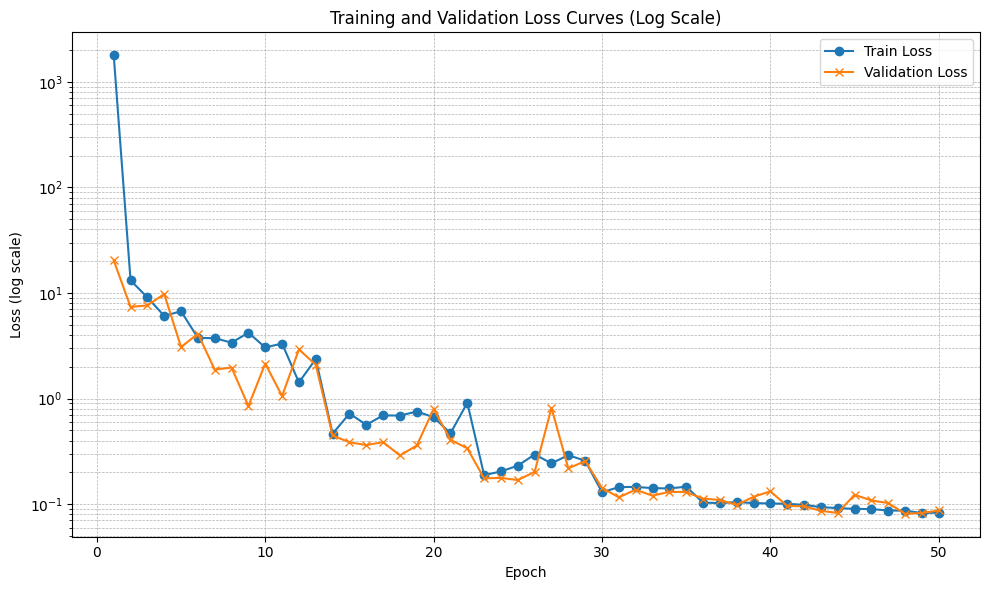

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Load log file
log_file = "training_log.txt"
epochs, train_losses, val_losses = [], [], []

with open(log_file, "r") as f:
    for line in f:
        if line.startswith("Epoch"):
            parts = line.strip().split(',')
            epoch = int(parts[0].split()[1])
            train_loss = float(parts[1].split(":")[1])
            val_loss = float(parts[2].split(":")[1])
            epochs.append(epoch)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

# Plotting with log scale on Y-axis
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.yscale('log')  # Set y-axis to log scale for visualization
plt.title("Training and Validation Loss Curves (Log Scale)")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

plt.savefig("loss_curve.png")

## Selection and Evaluation of Best Model from Candidates


--- Evaluating Candidate Models on Test Set ---
/content/best_model_valLoss0.1004_20250409_221052.pth --> Test Loss: 0.1115
/content/best_model_valLoss0.1068_20250409_220850.pth --> Test Loss: 0.1175
/content/best_model_valLoss0.1109_20250409_220448.pth --> Test Loss: 0.1236
/content/best_model_valLoss0.1179_20250409_215639.pth --> Test Loss: 0.1313
/content/best_model_valLoss0.1208_20250409_215036.pth --> Test Loss: 0.1346

 Best Model: /content/best_model_valLoss0.1004_20250409_221052.pth | Test Loss: 0.1115

Evaluation Metrics:
Total RMSE: 0.3343, MAE: 0.1762
Position RMSE: 0.2290 m, Yaw RMSE: 0.4799 rad


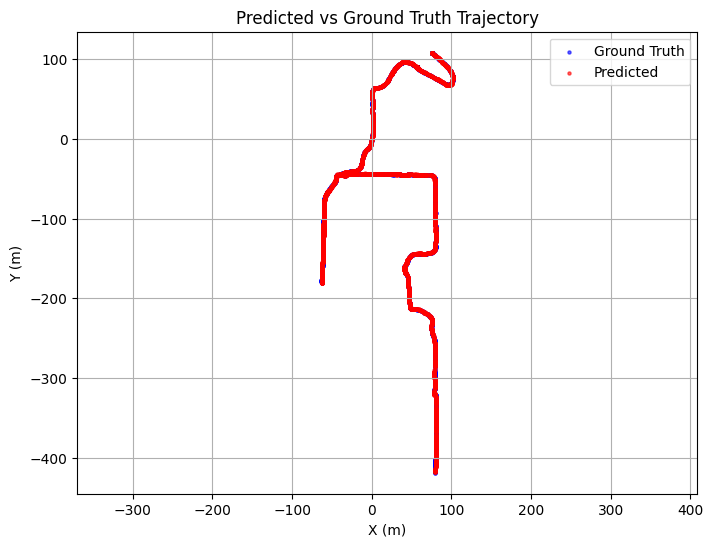

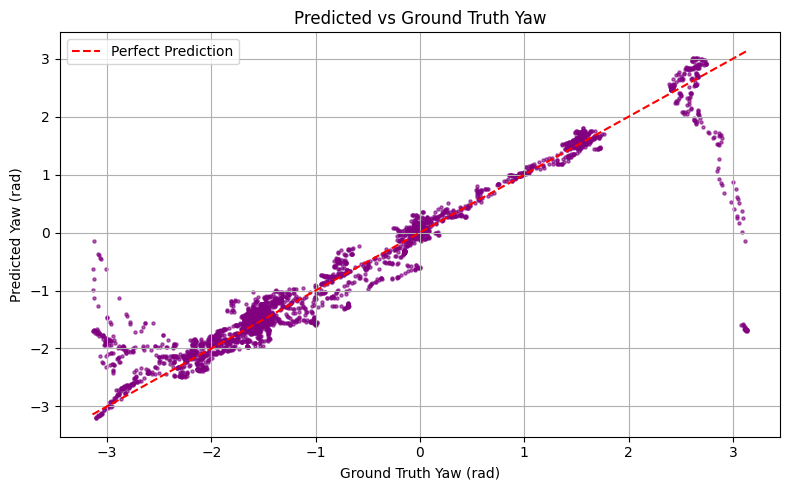

In [ ]:
def select_best_model_on_testset(model_class, model_args, model_paths, test_loader, criterion, device):
    """
    Evaluates multiple saved models and returns the one with the lowest test loss.
    """
    best_loss = float('inf')
    best_model_path = None
    best_preds, best_targets = None, None

    print("\n--- Evaluating Candidate Models on Test Set ---")
    for path in model_paths:
        model = model_class(**model_args).to(device)
        model.load_state_dict(torch.load(path))
        model.eval()

        test_loss, preds, targets = evaluate_model(model, test_loader, criterion, device)
        print(f"{path} --> Test Loss: {test_loss:.4f}")

        if test_loss < best_loss:
            best_loss = test_loss
            best_model_path = path
            best_preds = preds
            best_targets = targets

    print(f"\n Best Model: {best_model_path} | Test Loss: {best_loss:.4f}")
    return best_model_path, best_loss, best_preds, best_targets

# Best 5 models (hardcoded here to reproduce report results!)
model_paths = [
    "data//best_model_valLoss0.1004_20250409_221052.pth",
    "data/best_model_valLoss0.1068_20250409_220850.pth",
    "data/best_model_valLoss0.1109_20250409_220448.pth",
    "data/best_model_valLoss0.1179_20250409_215639.pth",
    "data/best_model_valLoss0.1208_20250409_215036.pth"
]

# Main code
model_args = {"lidar_dim": 1081}
best_path, best_loss, preds, targets = select_best_model_on_testset(
    model_class=OdometryLiDARNet,
    model_args=model_args,
    model_paths=model_paths,
    test_loader=test_loader,
    criterion=nn.MSELoss(),
    device=device
)

# Evaluate/plot position vs ground truth
evaluate_predictions(preds, targets, test_dataset)

# Evaluate/plot yaw vs ground truth (scatterplot)
plt.figure(figsize=(8, 5))
plt.scatter(targets[:, 2], preds[:, 2], alpha=0.6, s=5, c='purple')
plt.plot([targets[:, 2].min(), targets[:, 2].max()],
          [targets[:, 2].min(), targets[:, 2].max()],
          'r--', label='Perfect Prediction')

plt.xlabel('Ground Truth Yaw (rad)')
plt.ylabel('Predicted Yaw (rad)')
plt.title('Predicted vs Ground Truth Yaw')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Error Histograms


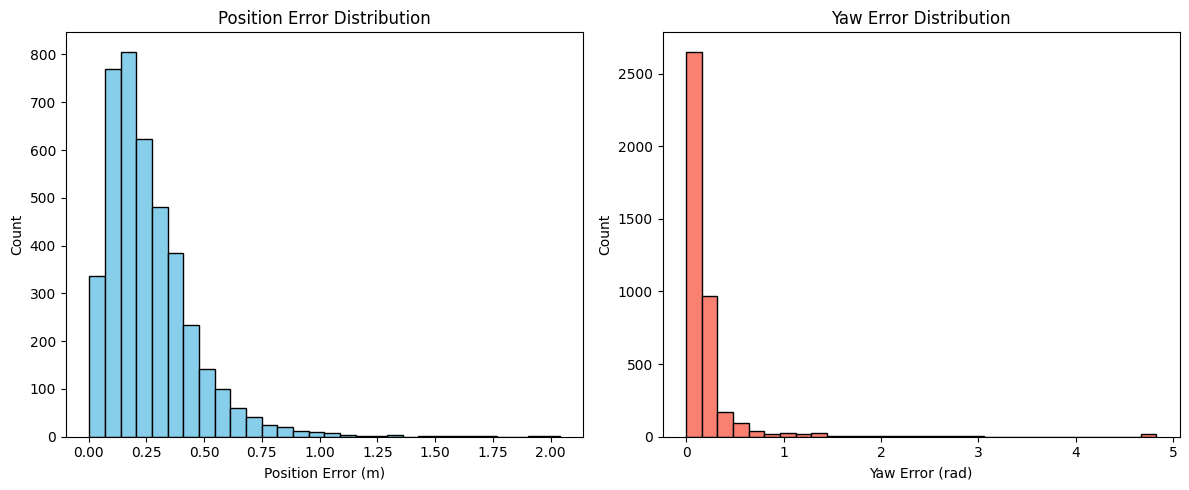

In [ ]:
def plot_error_distribution(preds, targets):
    preds = preds.numpy()
    targets = targets.numpy()
    pos_error = np.linalg.norm(preds[:, :2] - targets[:, :2], axis=1)
    yaw_error = np.abs(preds[:, 2] - targets[:, 2])

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(pos_error, bins=30, color='skyblue', edgecolor='black')
    plt.title("Position Error Distribution")
    plt.xlabel("Position Error (m)")
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    plt.hist(yaw_error, bins=30, color='salmon', edgecolor='black')
    plt.title("Yaw Error Distribution")
    plt.xlabel("Yaw Error (rad)")
    plt.ylabel("Count")

    plt.tight_layout()
    plt.show()

plot_error_distribution(preds, targets)

## Sampled (1%) of Testing Data vs Ground Truth

#### This plot provides a better visual of the quality of prediction by only plotting a random subset of 1% of the predictions and ground truth values.

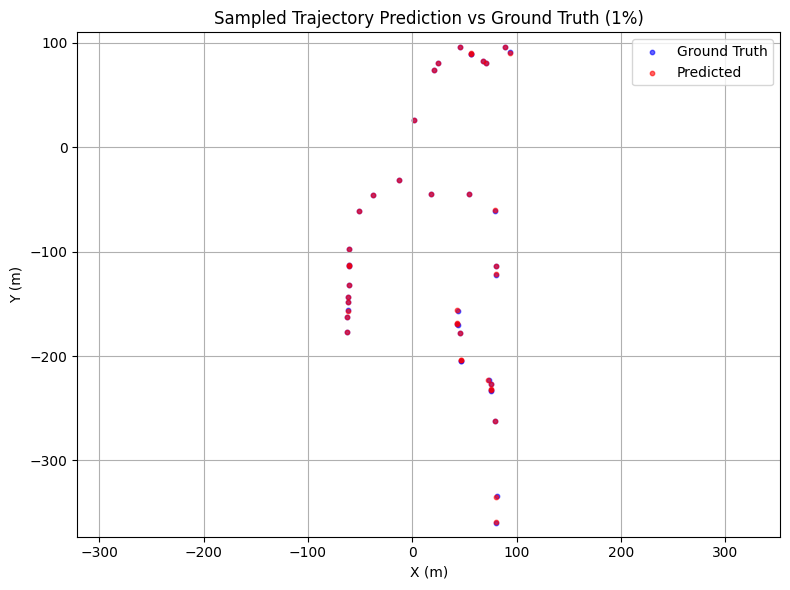

In [ ]:
def plot_trajectory_sampled(preds, targets, sample_ratio=0.01, seed=42):
    preds = preds.numpy()
    targets = targets.numpy()

    # Random sampling
    np.random.seed(seed)
    num_points = len(preds)
    sample_size = max(1, int(num_points * sample_ratio))
    indices = np.random.choice(num_points, size=sample_size, replace=False)

    sampled_preds = preds[indices]
    sampled_targets = targets[indices]

    plt.figure(figsize=(8, 6))
    plt.scatter(sampled_targets[:, 0], sampled_targets[:, 1], label="Ground Truth", c='blue', s=10, alpha=0.6)
    plt.scatter(sampled_preds[:, 0], sampled_preds[:, 1], label="Predicted", c='red', s=10, alpha=0.6)
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.title("Sampled Trajectory Prediction vs Ground Truth (1%)")
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_trajectory_sampled(preds, targets, sample_ratio=0.01)


## Raw Odometry Visualization and Evaluation


RMSE between Ground Truth and Transformed Odometry: 7.3520


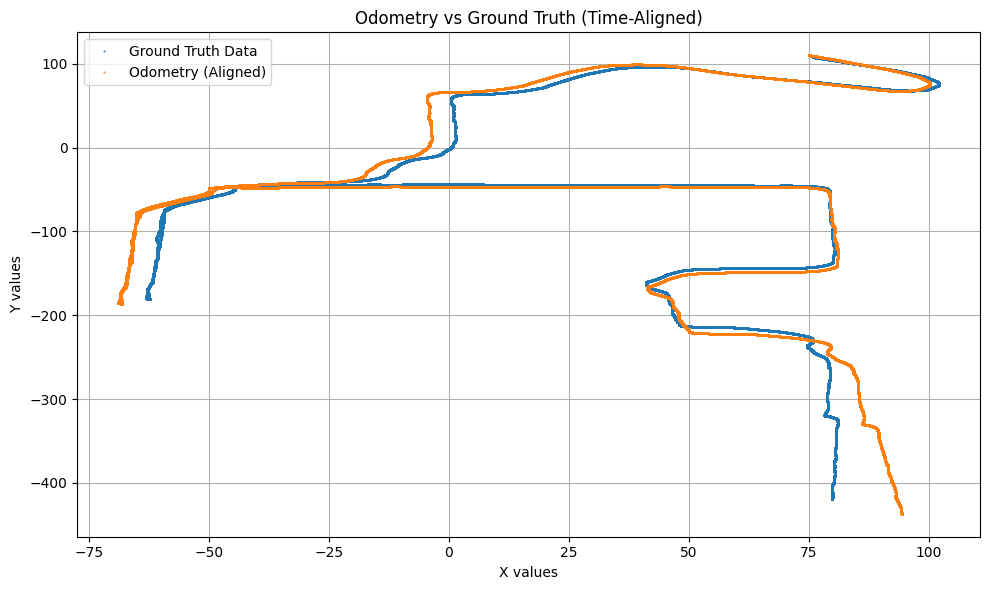

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# load datasets
ground_truth = pd.read_csv('data/groundtruth_2013-01-10.csv') #enter local csv path
odom = pd.read_csv(r'data/odometry_mu_100hz.csv', skiprows=112) #enter local csv path

# get timestamps and positions
t_gt = ground_truth.iloc[:, 0].to_numpy()
x_gt = ground_truth.iloc[:, 1].to_numpy()
y_gt = ground_truth.iloc[:, 2].to_numpy()

t_odom = odom.iloc[:, 0].to_numpy()
x_odom = odom.iloc[:, 1].to_numpy()
y_odom = odom.iloc[:, 2].to_numpy()

# apply rotation to odom data
theta_deg = -11
theta = np.radians(theta_deg)
R = np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta),  np.cos(theta)]
])
odom_coords = np.vstack((x_odom, y_odom))
rotated_coords = R @ odom_coords

# apply translation to odom data
t_x = 75
t_y = 110
x_translated = rotated_coords[0] + t_x
y_translated = rotated_coords[1] + t_y

# interpolate odom data to ground truth for metrics
interp_x = interp1d(t_gt, x_gt, kind='linear', bounds_error=False, fill_value='extrapolate')
interp_y = interp1d(t_gt, y_gt, kind='linear', bounds_error=False, fill_value='extrapolate')

x_gt_interp = interp_x(t_odom)
y_gt_interp = interp_y(t_odom)

# rmse calculation
squared_error = (x_gt_interp - x_translated)**2 + (y_gt_interp - y_translated)**2
rmse = np.sqrt(np.mean(squared_error))
print(f'RMSE between Ground Truth and Transformed Odometry: {rmse:.4f}')

# plotting code
plt.figure(figsize=(10, 6))
plt.plot(x_gt, y_gt, '.', markersize=1, label='Ground Truth Data')
plt.plot(x_translated, y_translated, '.', markersize=1, label='Odometry (Aligned)')
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Odometry vs Ground Truth (Time-Aligned)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()